In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

## Comparison of Stan model to kaggle data analysis:

### Read in Data:

In [2]:
data = pd.read_csv("CarPrice_Assignment.csv")
data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


### Data Preprocessing (same as kaggle analysis):

In [3]:
# Extract brand and model from CarName
data['brand'] = data['CarName'].apply(lambda x: x.split(' ')[0])
data['model'] = data['CarName'].apply(lambda x: ' '.join(x.split(' ')[1:]))

# Define categorical and numerical columns
categorical_columns = ['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel',
                       'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem', 'brand', 'model']
numerical_columns = ['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
                     'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
                     'peakrpm', 'citympg', 'highwaympg']

# Encoding categorical variables
label_encoder = LabelEncoder()
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column])

# Feature engineering
data['power_to_weight_ratio'] = data['horsepower'] / data['curbweight']
for column in numerical_columns:
    data[f'{column}_squared'] = data[column] ** 2
data['log_enginesize'] = np.log(data['enginesize'] + 1)

# Feature scaling
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,curbweight_squared,enginesize_squared,boreratio_squared,stroke_squared,compressionratio_squared,horsepower_squared,peakrpm_squared,citympg_squared,highwaympg_squared,log_enginesize
0,1,3,alfa-romero giulia,1,0,1,0,2,0,-1.690772,...,6492304,16900,12.0409,7.1824,81.0,12321,25000000,441,729,4.875197
1,2,3,alfa-romero stelvio,1,0,1,0,2,0,-1.690772,...,6492304,16900,12.0409,7.1824,81.0,12321,25000000,441,729,4.875197
2,3,1,alfa-romero Quadrifoglio,1,0,1,2,2,0,-0.708596,...,7969329,23104,7.1824,12.0409,81.0,23716,25000000,361,676,5.030438
3,4,2,audi 100 ls,1,0,0,3,1,0,0.173698,...,5461569,11881,10.1761,11.5600,100.0,10404,30250000,576,900,4.700480
4,5,2,audi 100ls,1,0,0,3,0,0,0.107110,...,7974976,18496,10.1761,11.5600,64.0,13225,30250000,324,484,4.919981


<Axes: xlabel='price', ylabel='Count'>

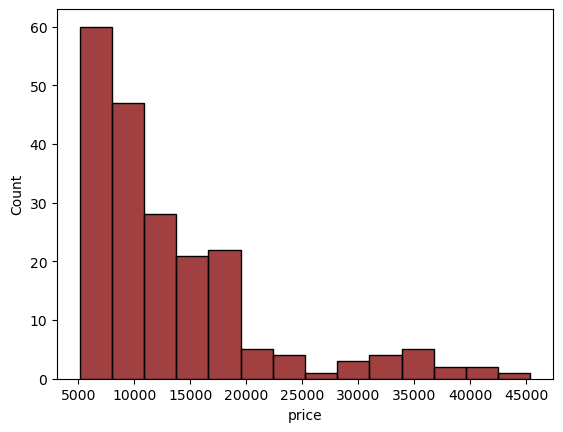

In [4]:
# Inspect the price data
sns.histplot(data.price, color='maroon')

<Axes: xlabel='price', ylabel='Count'>

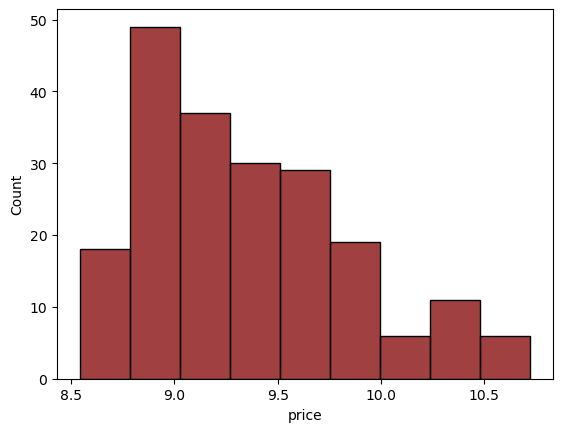

In [5]:
# Price data is not normally distribited, so do log transform
log_price = np.log(data.price)
sns.histplot(log_price, color='maroon')

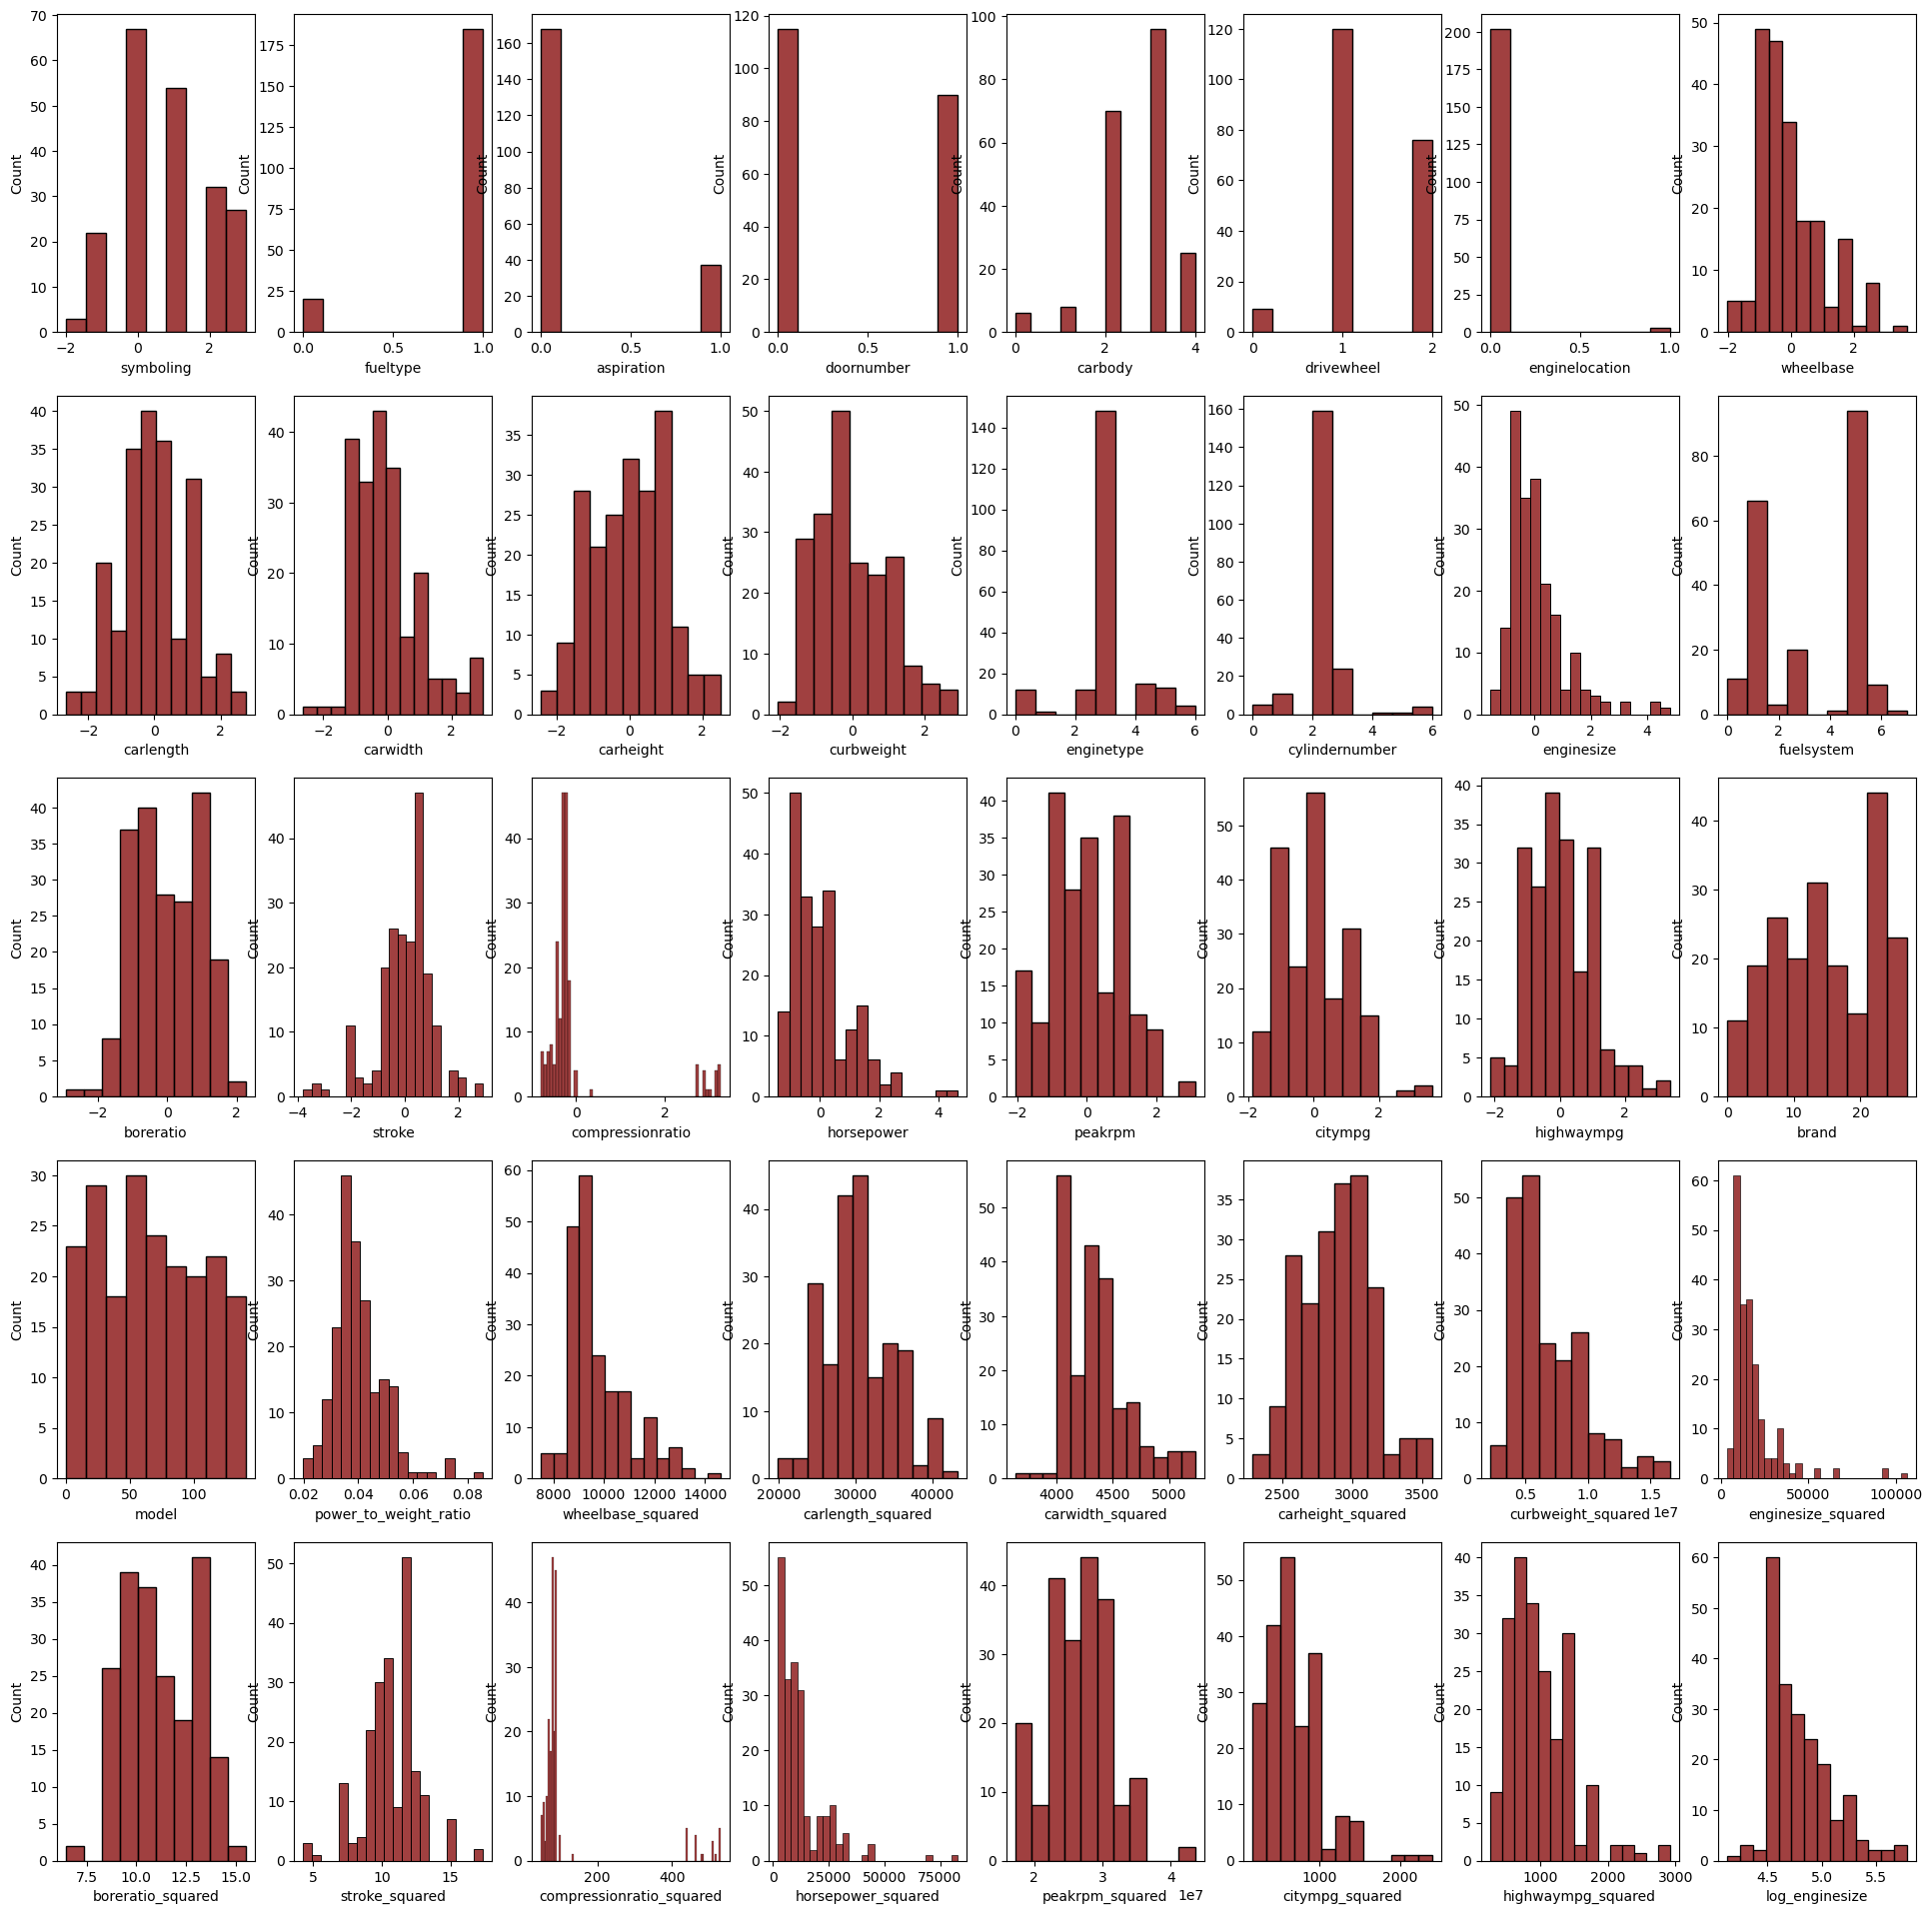

In [6]:
# Inspect histplots of all features
_, ax = plt.subplots(5, 8, figsize=(24, 24))
ax = ax.flatten()
cols = np.array(data.columns)
cols = cols[cols != 'car_ID']
cols = cols[cols != 'CarName']
cols = cols[cols != 'price']
for col, a in zip(cols, ax):
    sns.histplot(data[col], ax=a, color='maroon')

In [7]:
# Use all possible features (don't use squared or logged features that kaggle analysis uses, this makes model not converge)
use_data = data.iloc[:, :29].drop(['car_ID', 'CarName', 'price'], axis=1)
use_data.columns

Index(['symboling', 'fueltype', 'aspiration', 'doornumber', 'carbody',
       'drivewheel', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize',
       'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'brand', 'model',
       'power_to_weight_ratio'],
      dtype='object')

In [8]:
# Split data into train and test set
X = np.array(use_data)
y = np.array(log_price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression Stan Model:

In [9]:
program_code = """
data {
    int<lower=1> N;
    int<lower=0> K;
    matrix[N, K] X;
    vector[N] y;
    int<lower=1> N_test;
    matrix[N_test, K] X_test;
    real mu1;
    real mu2;
    real mu3;
    real sd1;
    real sd2;
    real sd3;
}

parameters {
    real<lower=0> sigma;
    real alpha;
    vector[K] beta;
}

model {
    // Priors
    sigma ~ normal(mu1, sd1);
    alpha ~ normal(mu2, sd2);
    beta ~ normal(mu2, sd3);

    // Likelihood
    y ~ normal(alpha + X * beta, sigma);
}

generated quantities {
    array[N] real gen_y;
    gen_y = normal_rng(alpha + X * beta, sigma);

    array[N_test] real pred_y;
    pred_y = normal_rng(alpha + X_test * beta, sigma);
}
"""

In [10]:
# Prepare data in Stan friendly format
data_dict = {
    'N': X_train.shape[0],
    'K': X_train.shape[1],
    'X': X_train,
    'y': y_train,
    'N_test': X_test.shape[0],
    'X_test': X_test,
    'mu1': 0, #mu and sd are for testing different priors
    'mu2': 9.2,
    'mu3': 9.2,
    'sd1': 10,
    'sd2': 9.2,
    'sd3': 9.2
}

# Compile model
regression_model = stan.build(program_code, data=data_dict)

# Sample 4 x 2000 random draws from the posterior
regression_fit = regression_model.sample(num_chains=4, num_warmup=1000, num_samples=2000)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (202/12000)
Sampling:   3% (301/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1500/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling: 

In [11]:
regression_results = regression_fit.to_frame()
regression_results.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,alpha,beta.1,...,pred_y.32,pred_y.33,pred_y.34,pred_y.35,pred_y.36,pred_y.37,pred_y.38,pred_y.39,pred_y.40,pred_y.41
draws,,,,,,,,,,,,,,,,,,,,,
0,211.342742,0.942364,0.014807,8.0,255.0,0.0,-201.061148,0.147371,8.529841,-0.017325,...,8.932871,8.886714,9.564455,9.335411,10.406880,9.235845,9.402341,8.666116,9.386430,8.783658
1,213.712300,0.965595,0.017215,8.0,255.0,0.0,-204.122339,0.148786,7.927789,0.017966,...,8.783976,8.763686,9.693564,8.785135,10.387167,9.091534,9.113564,8.821075,9.465788,8.914000
2,213.395471,0.962062,0.015866,8.0,255.0,0.0,-200.670637,0.145939,8.759818,0.018459,...,8.835102,8.762962,9.781117,9.121092,10.353469,9.341951,9.336393,8.954515,9.467774,8.944684
3,203.963056,0.999286,0.015699,8.0,511.0,0.0,-188.444795,0.152214,7.543042,-0.009808,...,9.119327,8.892702,9.834389,9.307376,10.521230,9.454866,9.185704,8.676896,9.579931,9.068306
4,212.098984,0.961759,0.014807,7.0,255.0,0.0,-196.137267,0.146629,8.586810,-0.012263,...,8.782570,8.784125,9.611758,9.410543,10.196694,9.206418,9.337361,8.953492,9.677632,9.156689


In [12]:
regression_summary = az.summary(regression_fit)
regression_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.153,0.010,0.136,0.172,0.000,0.000,8257.0,5499.0,1.0
alpha,8.398,0.493,7.493,9.343,0.009,0.006,3024.0,4099.0,1.0
beta[0],-0.001,0.017,-0.033,0.030,0.000,0.000,6688.0,6152.0,1.0
beta[1],0.885,0.410,0.125,1.652,0.007,0.005,3253.0,4406.0,1.0
beta[2],0.052,0.054,-0.045,0.158,0.001,0.001,5571.0,5743.0,1.0
...,...,...,...,...,...,...,...,...,...
pred_y[36],9.270,0.170,8.957,9.599,0.002,0.001,8084.0,7563.0,1.0
pred_y[37],9.328,0.175,8.993,9.646,0.002,0.001,7807.0,7675.0,1.0
pred_y[38],8.734,0.164,8.410,9.032,0.002,0.001,7918.0,7961.0,1.0
pred_y[39],9.519,0.163,9.220,9.838,0.002,0.001,8005.0,7632.0,1.0


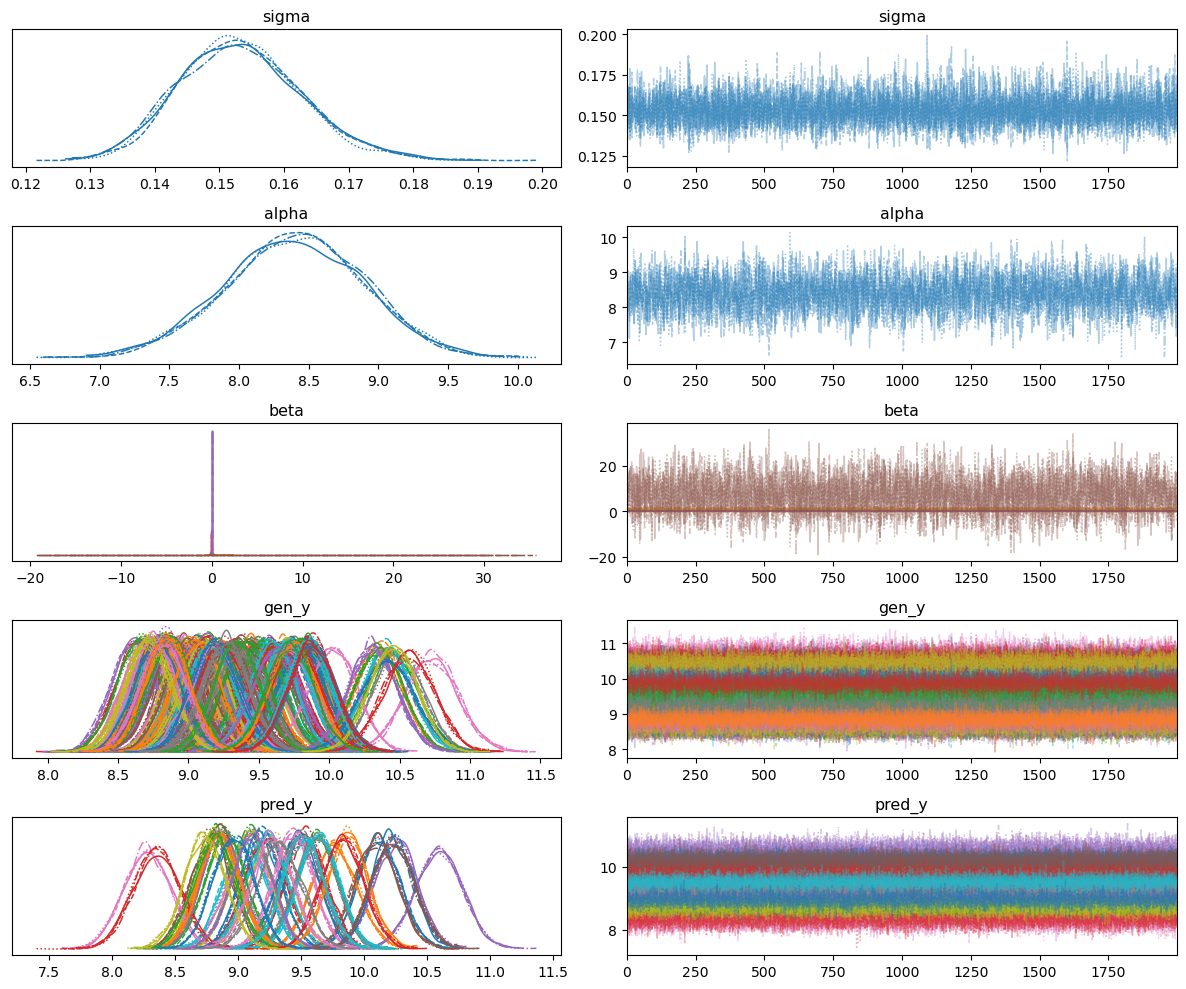

In [13]:
_ = az.plot_trace(regression_fit)
plt.tight_layout()

<Axes: ylabel='Density'>

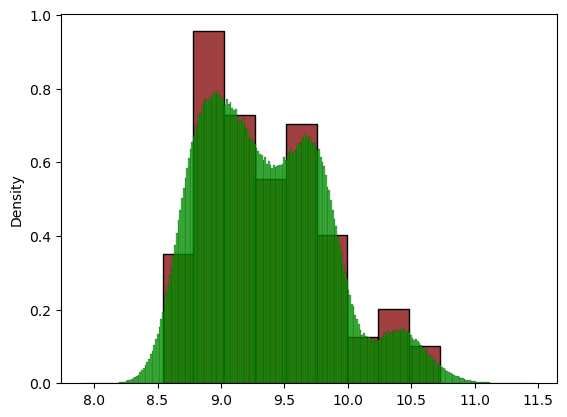

In [14]:
# Marginal Check (Generative)
sns.histplot(y_train, color='maroon', stat='density')
sns.histplot(regression_results.iloc[:, 35:199].values.flatten(), stat='density', color='#00AA00')

<Axes: ylabel='Density'>

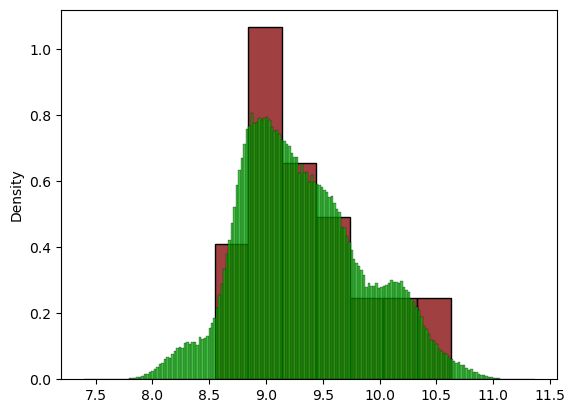

In [18]:
# Marginal Check (Predictive)
sns.histplot(y_test, color='maroon', stat='density')
sns.histplot(regression_results.iloc[:, 199:].values.flatten(), stat='density', color='#00AA00')

In [15]:
# Generative Performance
preds = regression_fit.__getitem__('gen_y')
preds_mean = preds.mean(axis=1)
rmse = np.sqrt(np.mean((preds_mean - y_train)**2))
r2 = r2_score(y_train, preds_mean)
print("RMSE:", rmse)
print("R2-Score:", r2)

RMSE: 0.13937260834787116
R2-Score: 0.9216412536511847


In [16]:
# Predictive Performance
preds = regression_fit.__getitem__('pred_y')
preds_mean = preds.mean(axis=1)
rmse = np.sqrt(np.mean((preds_mean - y_test)**2))
r2 = r2_score(y_test, preds_mean)
print("RMSE:", rmse)
print("R2-Score:", r2)

RMSE: 0.1815221951901453
R2-Score: 0.8785579799252683


In [17]:
# Betas (check which have the most influence)
betas = regression_fit.__getitem__('beta')
betas_mean = betas.mean(axis=1)
betas_mean

array([-1.42129174e-03,  8.84506935e-01,  5.17567771e-02, -7.38867942e-02,
       -6.95136459e-02,  3.70294902e-02,  4.82795989e-01,  2.54839620e-02,
        2.18226311e-02,  5.33743878e-02,  3.08751582e-02,  2.06566324e-01,
        1.27991515e-02, -1.16689796e-02,  3.76265556e-02,  3.29043527e-02,
        5.78446280e-03, -2.24115285e-02,  3.29044153e-01, -2.31710909e-02,
        2.45753869e-02, -1.79263900e-01,  8.87597186e-02, -9.27813817e-03,
        4.59051533e-04,  7.09652794e+00])